In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

## 2. Implement template-matching in Python using SSD, NCC, SAD

In [2]:
# template mtching methods:
ssd = lambda img1, img2: np.sum( (img1 - img2) ** 2)
ncc = lambda img1, img2: np.sum( normalize(img1)  * normalize(img2) )
def sad(img1, img2):
    return np.sum( np.abs(img1 - img2) )

def normalize(img):
    img = img - np.mean(img)
    return img / np.linalg.norm(img)

# Apply matching method to image. It works like conv2d method, but it is not only matrix multiplication 
def matchTemplateToImg(img, template, matcher):
    t_h,t_w = template.shape
    img_h, img_w = img.shape
    match_results = np.zeros((img_h-t_h+1, img_w-t_w+1))

    for y in range(match_results.shape[0]):
        for x in range(match_results.shape[1]):
            window = img[y:y+t_h, x:x+t_w]
            if (window.shape != template.shape):
                continue

            match_results[y,x] = matcher(window, template)
    
    return match_results

# Apply matching method to image. But with knowing the previous point where template was matched.
# We search for template from prev point (x,y) with soem redius. It allows algorithm to work faster
# and do not overlap with other object that are similar to template.
def matchTemplateToImgZone(img, template, matcher, prev_point=False, radius=0, fill=0):
    t_h,t_w = template.shape
    img_h, img_w = img.shape
    match_results = np.zeros((img_h-t_h+1, img_w-t_w+1)) + fill
    
    if prev_point[0] < radius:
        prev_point = (radius+1, prev_point[1])
    if prev_point[0] + radius + t_h > img_h:
        prev_point = (img_h - radius - t_h - 1 , prev_point[1])
    if prev_point[1] < radius:
        prev_point = (prev_point[0], radius+1)
    if prev_point[1] + radius + t_h > img_h:
        prev_point = (prev_point[0], img_h - radius - t_h - 1)

    match_zone = np.zeros((radius*2,radius*2))

    for y in range(radius*2):
        for x in range(radius*2):
            start_y = prev_point[0] + y - radius
            start_x = prev_point[1] + x - radius
            window = img[
                start_y : start_y + t_h,
                start_x : start_x + t_w,
            ]
            if (window.shape != template.shape):
                match_zone[y,x]=fill
                continue

            match_zone[y,x] = matcher(window, template)
    
    match_zone = match_zone / match_zone.max()
    match_results[prev_point[0]-radius:prev_point[0]+radius, prev_point[1]-radius:prev_point[1]+radius] = match_zone
    
    return match_results

Dataset Biker loaded!


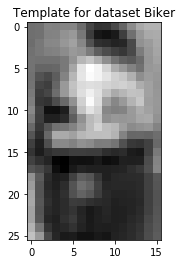

Dataset football loaded!


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

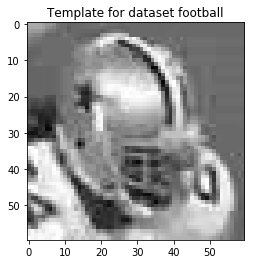

Dataset Coke loaded!


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

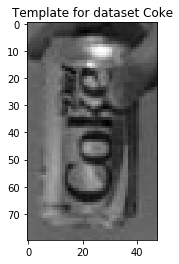

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [6]:
from tqdm import tqdm_notebook
import os, os.path

# dtaset list
datasets = ['Biker', 'football', 'Coke']
# points with template roi. I get them from dataset file
roi_s = {
    'football': ((300,100),(60,60)),
    'Biker': ((262, 94), (16, 26)),
    'Coke': ((298, 160), (48, 80)),
}
# methods to apply
methods = ["sad", "ssd", "ncc"]
methods_dict = {
    "sad": sad,
    "ssd": ssd,
    "ncc": ncc,
}
# Radius search from previous target position
radius_search = 30

for dataset in datasets:
    img_l = len([name for name in os.listdir(f'./datasets/{dataset}/img')])
    images = [cv2.imread(f"./datasets/{dataset}/img/{str(i).zfill(4)}.jpg", 0) for i in range(1,img_l+1)]
    print(f"Dataset {dataset} loaded!")
    
    roi = roi_s[dataset]
    # get template image for dataset
    template = images[0][roi[0][1]:roi[0][1]+roi[1][1], roi[0][0]:roi[0][0] + roi[1][0]]
    t_h, t_w = template.shape
    
    plt.title(f"Template for dataset {dataset}")
    plt.imshow(template, cmap='gray')
    plt.show()
    
    for method in methods:
        # get matcher function
        matcher = methods_dict[method]
        # for video saving
        img_results = []
        
        # previous point. init with empty.
        h,w = (False,False)
        
        for img in tqdm_notebook(images, 
                         desc=f"Processing Dataset={dataset}, method={method}"):
            if (h and w):
                # As we search by radius background point should be filled by some values.
                if (method=="ncc"):
                    # for NCC it should be ones. As in NCC case we are searching for MAX value
                    match_result = matchTemplateToImgZone(img, template, matcher, prev_point=(h,w), radius=radius_search)
                else:
                    # for other it should be zeros.
                    match_result = matchTemplateToImgZone(img, template, matcher, prev_point=(h,w), radius=radius_search, fill=1)

            else:
                # first template search
                match_result = matchTemplateToImg(img, template, matcher)

            if method == "ncc":
                h,w = np.unravel_index(np.argmax(match_result, axis=None), match_result.shape)
            else:
                h,w = np.unravel_index(np.argmin(match_result, axis=None), match_result.shape)

            img_marked = img.copy()
            # draw a rectangle
            cv2.rectangle(img_marked, (w,h), (w+t_w,h+t_h), 255, 3)
            # save image to video list
            img_results.append(img_marked)

        from matplotlib import animation, rc
        
        # below code for video saving..
        fig = plt.figure()
        video_img = [[plt.imshow(img, cmap='gray')] for img in img_results]
        plt.clf()
        # ATTENTION: may need some changes here to work locally.
        # for mac suer run: $ brew install ffmpeg
        plt.rcParams['animation.ffmpeg_path'] = u'/usr/local/bin/ffmpeg'
        ani = animation.ArtistAnimation(fig, video_img, interval=500, blit=True, repeat_delay=1000)
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
        ani.save(f"results/template-matching/{dataset}_{method}.mp4", writer=writer)

From above results we can see that template matching works only when template is not transorfming on the next screens.

It works only if the remplate is moving on the image by (x,y) coordinates which is not enough in some cases.

Also from three methods SAD, SSD and NCC, NCC work the best because it is using not difference between pixels but normalize them which allow algorithm to match template into zones where brightness of the image is changing(the object is in the shadow for example)